# Image to image with Azure Computer Vision and Azure Open AI

We are going to use Bing Image search to get an image from Bing using a prompt. 
Then we are going to use **Azure Computer Vision 4 Florence** to get the main caption and the tags from the Bing image.
Then we will use this caption as a prompt to generate an artificial image using **Azure Open AI and its Dall e 2** integration.

In [1]:
import datetime
import glob
import openai
import os
import requests
import sys
import time

from dotenv import load_dotenv
from io import BytesIO
from IPython.display import Image as viewimage
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
sys.version

'3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]'

In [3]:
print("Today:", datetime.datetime.today().strftime("%d-%b-%Y %H:%M:%S"))

Today: 21-Sep-2023 08:04:19


In [4]:
IMAGES_DIR = "bing_images"
RESULTS_DIR = "artificial_images"

os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

## Functions

In [5]:
def image_bing_search(search_term, idx=0):
    """
    Get image from Bing Search
    """
    # Get key and endpoint for the Bing Search service
    load_dotenv("azure.env")
    bing_key = os.getenv("bing_key")
    bing_search_url = os.getenv("bing_search_url")

    # Settings
    headers = {"Ocp-Apim-Subscription-Key": bing_key}
    params = {"q": search_term, "license": "public", "imageType": "photo"}

    # Running the bing search service
    response = requests.get(bing_search_url, headers=headers, params=params)

    response.raise_for_status()
    search_results = response.json()

    # Getting the image
    thumbnail_url = search_results["value"][idx]["thumbnailUrl"]
    image = requests.get(thumbnail_url)
    image.raise_for_status()
    img = Image.open(BytesIO(image.content))

    # Saving the image
    output_file = os.path.join(IMAGES_DIR, search_term + ".jpg")
    img.save(output_file)

    return img, output_file

In [6]:
def get_caption(image_file):
    """
    Get caption from an image using Azure Computer Vision 4
    """
    # Get key and endpoint for Azure Computer Vision service
    load_dotenv("azure.env")
    key = os.getenv("azure_cv_key")
    endpoint = os.getenv("azure_cv_endpoint")

    # settings
    options = "&features=caption,tags"
    model = "?api-version=2023-02-01-preview&modelVersion=latest"
    url = endpoint + "/computervision/imageanalysis:analyze" + model + options
    headers = {
        "Content-type": "application/octet-stream",
        "Ocp-Apim-Subscription-Key": key,
    }

    # Read the image file
    with open(image_file, "rb") as f:
        data = f.read()

    # Sending the requests
    response = requests.post(url, data=data, headers=headers)
    results = response.json()

    # Parsing the results
    image_caption = results["captionResult"]["text"]
    tags = results["tagsResult"]["values"]
    tags_string = ", ".join(item["name"] for item in tags)
    caption = image_caption + ", " + tags_string

    return caption

In [7]:
def dalle2(prompt, size=1024):
    """
    Generate an image from a prompt with Dall e 2
    """
    # prompt
    extra_prompt = "full view, detailled, 8K"
    image_prompt = prompt + extra_prompt

    # Get the endpoint and key for Azure Open AI
    load_dotenv("azure.env")
    openai.api_base = os.getenv("azure_openai_endpoint")
    openai.api_key = os.getenv("azure_openai_key")

    api_version = "2023-06-01-preview"
    url = (
        f"{openai.api_base}/openai/images/generations:submit?api-version={api_version}"
    )
    headers = {
        "api-key": openai.api_key,
        "Content-Type": "application/json",
    }

    if size == 512:
        imagesize = "512x512"
    elif size == 1024:
        imagesize = "1024x1024"
    elif size == 256:
        imagesize = "256x256"
    else:
        imagesize = "1024x1024"

    body = {"prompt": image_prompt, "size": imagesize, "n": 1}

    submission = requests.post(url, headers=headers, json=body)
    operation_location = submission.headers["operation-location"]
    status = ""

    while status != "succeeded":
        time.sleep(1)
        response = requests.get(operation_location, headers=headers)
        status = response.json()["status"]

    # Get the first generated image
    image_url = response.json()["result"]["data"][0]["url"]
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))

    # Saving the artificial image
    output_file = os.path.join(RESULTS_DIR, "dalle2_" + search_term + ".jpg")
    img.save(output_file)

    return img, output_file

In [8]:
def display_images(imagefile1, imagefile2):
    """
    Display two images side by side
    """
    # Reading images
    img1 = plt.imread(imagefile1)
    img2 = plt.imread(imagefile2)

    # Subplots
    f, ax = plt.subplots(1, 2, figsize=(15, 8))
    ax[0].imshow(img1)
    ax[1].imshow(img2)

    # Titles
    ax[0].set_title("Bing Search image")
    ax[1].set_title("DALL·E 2 artificial image")
    title = "Image to image with Bing Search, Azure Computer Vision and Azure Open AI"
    f.suptitle(title, fontsize=15)
    plt.tight_layout()

    # Removing the axis
    ax[0].axis("off")
    ax[1].axis("off")

    plt.show()

## Testing

### Test 1

In [70]:
search_term = "a portrait of a man, ages 30-40"

bing_images/a portrait of a man, ages 30-40.jpg


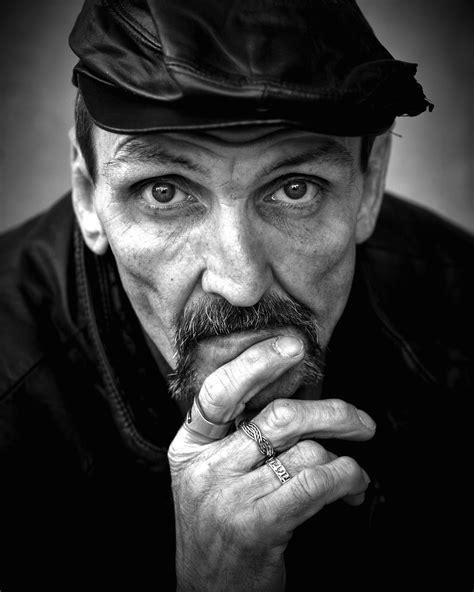

In [71]:
img, image_file = image_bing_search(search_term, idx=1)

print(image_file)
viewimage(filename=image_file, width=512)

In [72]:
prompt = get_caption(image_file)
prompt

'a man with a hat and a mustache, human face, person, black and white, portrait, man, moustache, clothing, facial hair, wrinkle, human beard, smoking, wearing, black, monochrome, indoor, hat'

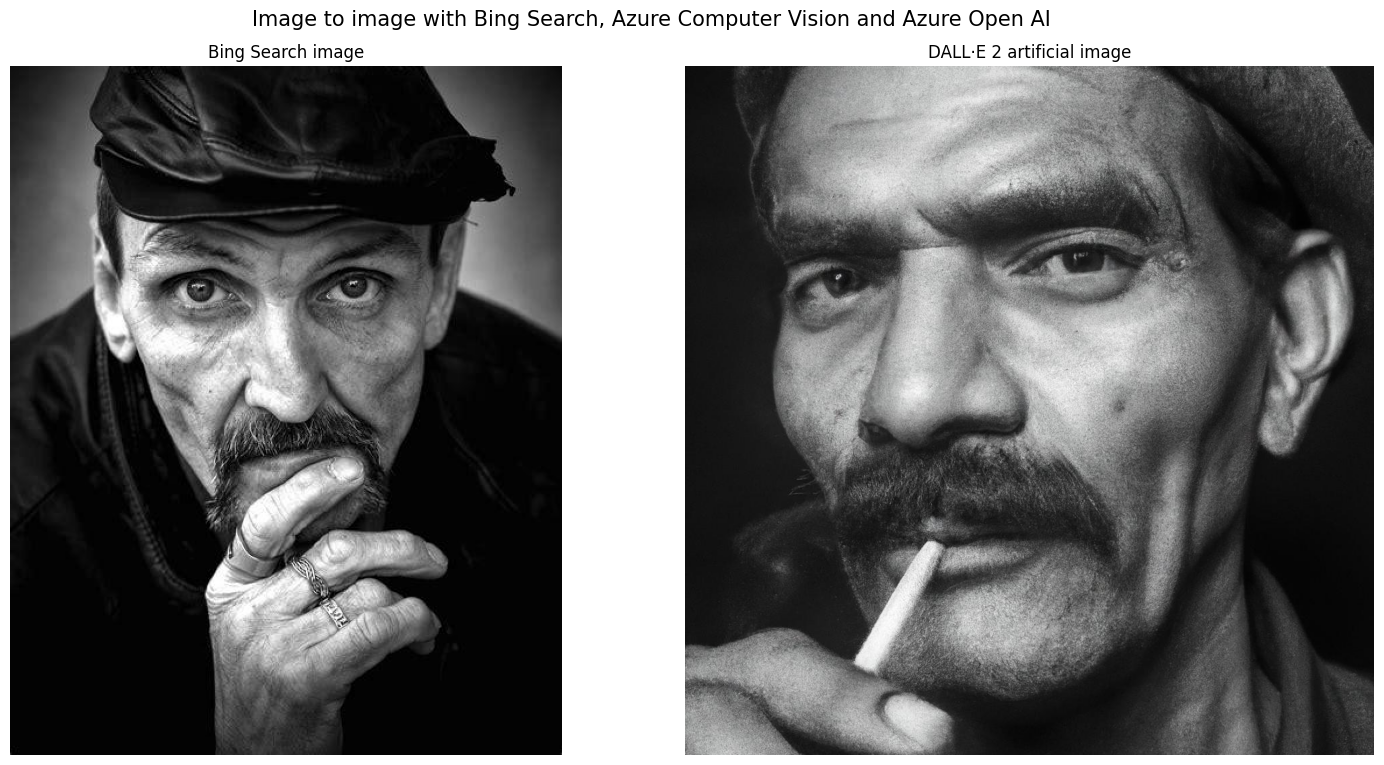

In [73]:
artificial_img, artificial_image = dalle2(prompt)

display_images(image_file, artificial_image)

### Test 2

In [13]:
search_term = "a red motorcycle in a street"

bing_images/a red motorcycle in a street.jpg


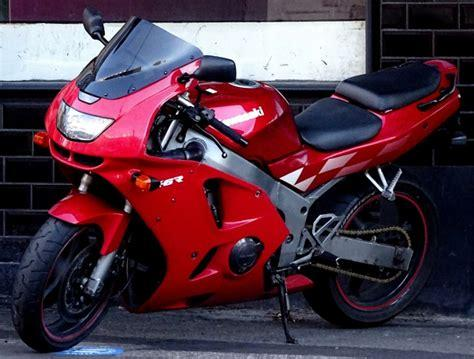

In [14]:
img, image_file = image_bing_search(search_term, idx=1)

print(image_file)
viewimage(filename=image_file, width=512)

In [15]:
prompt = get_caption(image_file)
prompt

'a red motorcycle parked on the pavement, motorcycle, vehicle, land vehicle, tire, wheel, motorbike, outdoor, auto part, red, brake, motorcycle fairing, fuel tank, vehicle brake, scooter, automotive exhaust, parked, muffler, fender, moped, rim, disc brake, exhaust system, road, automotive lighting, bike, ground, street'

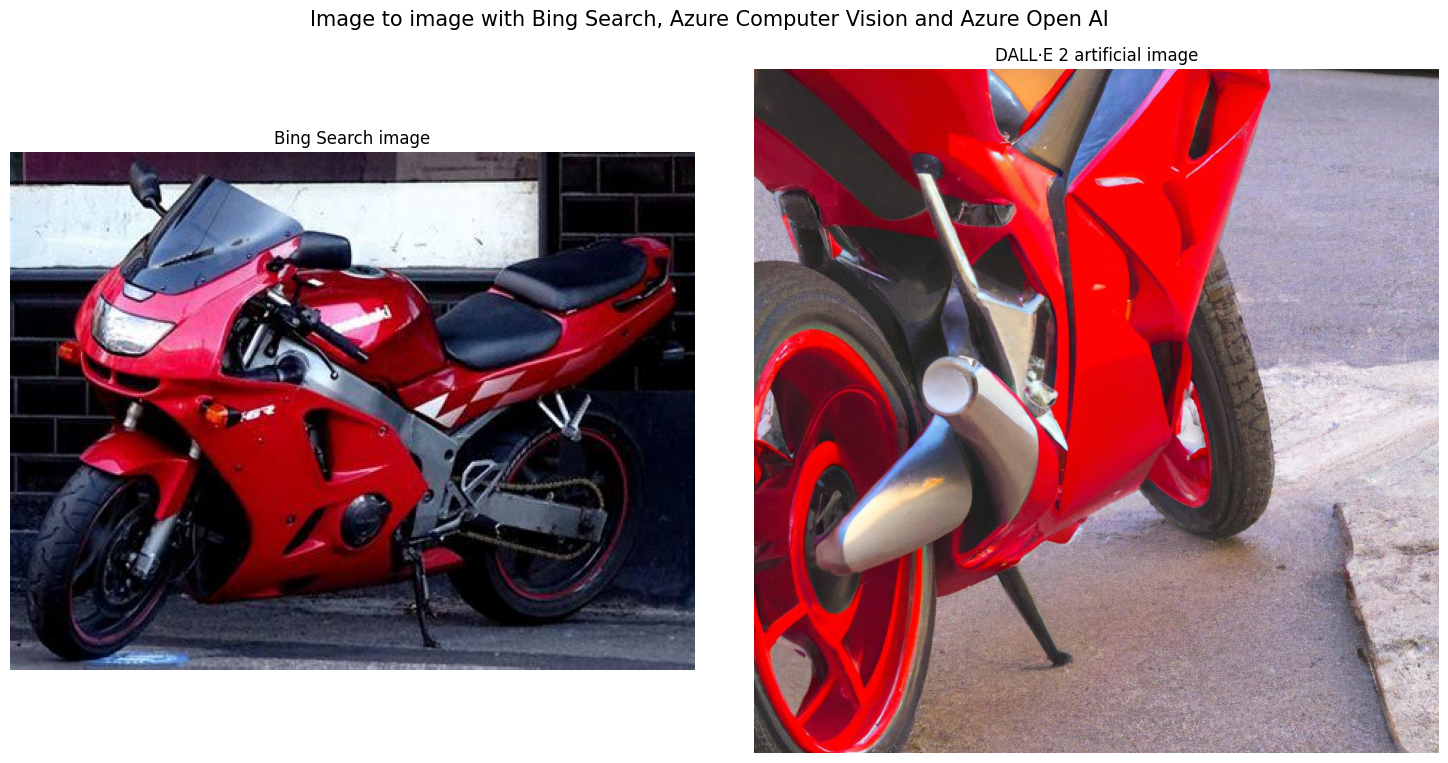

In [16]:
artificial_img, artificial_image = dalle2(prompt)

display_images(image_file, artificial_image)

### Test 3

In [56]:
search_term = "lake view from a drone"

bing_images/lake view from a drone.jpg


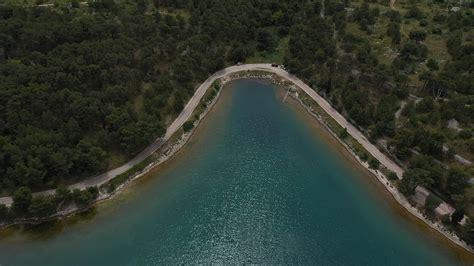

In [57]:
img, image_file = image_bing_search(search_term, idx=1)

print(image_file)
viewimage(filename=image_file, width=512)

In [58]:
prompt = get_caption(image_file)
prompt

'a road going through a body of water, outdoor, tree, water resources, body of water, aerial photography, water, island, aerial, coastal and oceanic landforms, mountain, nature'

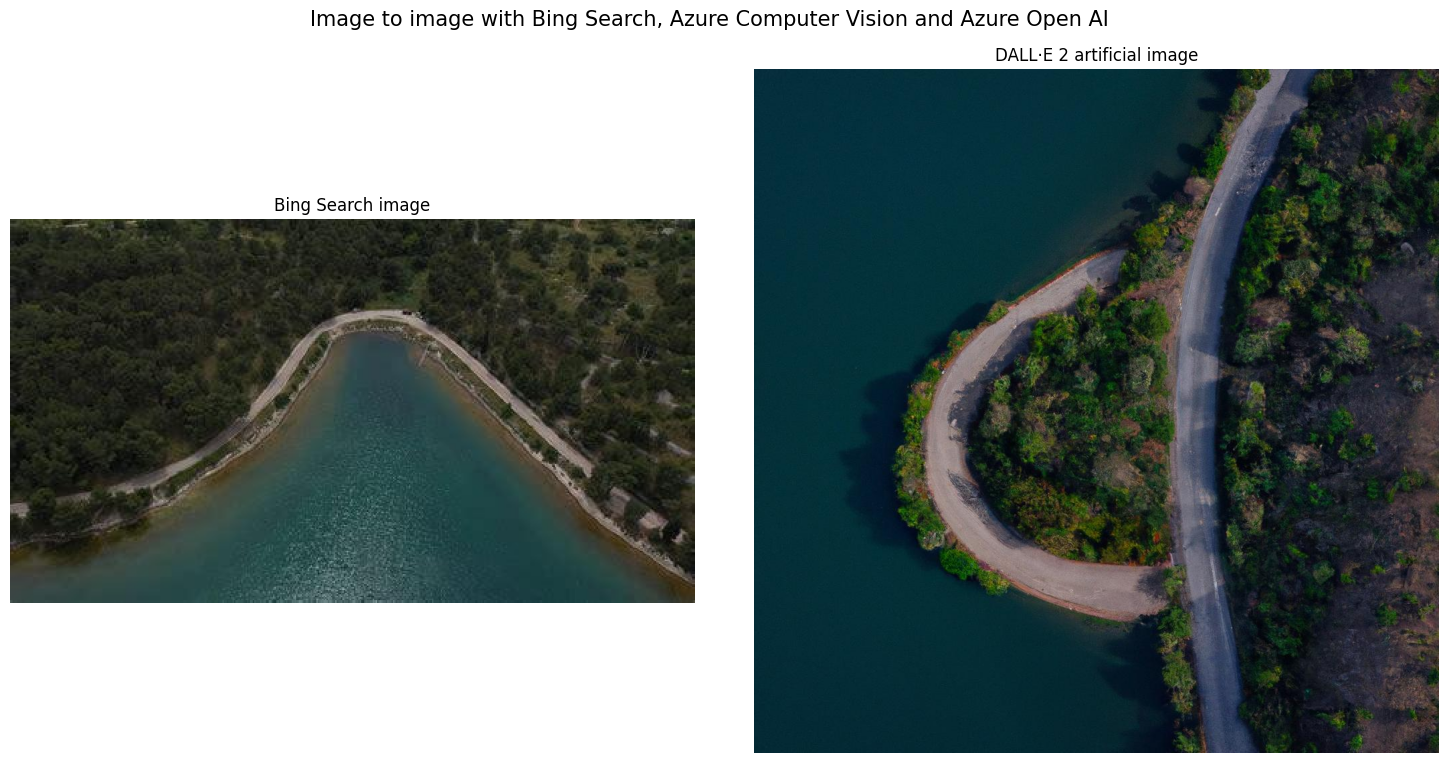

In [59]:
artificial_img, artificial_image = dalle2(prompt)

display_images(image_file, artificial_image)

### Test 4

In [48]:
search_term = "beautiful garden with trees and a pond"

bing_images/beautiful garden with trees and a pond.jpg


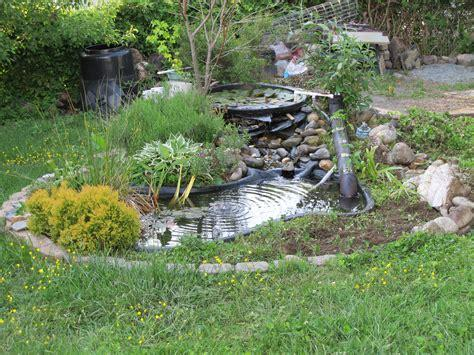

In [49]:
img, image_file = image_bing_search(search_term, idx=1)

print(image_file)
viewimage(filename=image_file, width=512)

In [50]:
prompt = get_caption(image_file)
prompt

'a pond with water flowing out of it, outdoor, grass, tree, flower, garden, groundcover, water, landscaping, plant, rock'

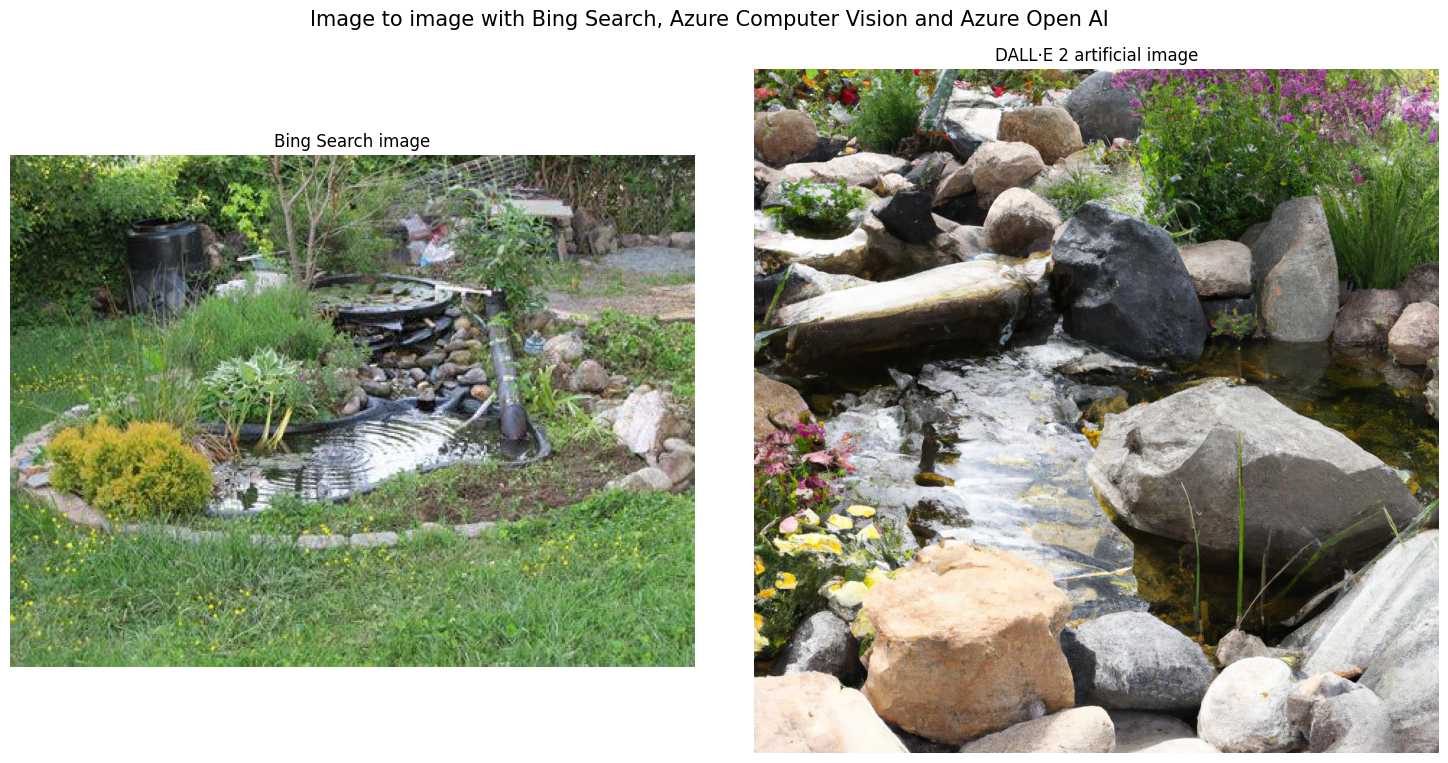

In [51]:
artificial_img, artificial_image = dalle2(prompt)

display_images(image_file, artificial_image)

### Test 5

In [25]:
search_term = "a mountain peak with clouds"

bing_images/a mountain peak with clouds.jpg


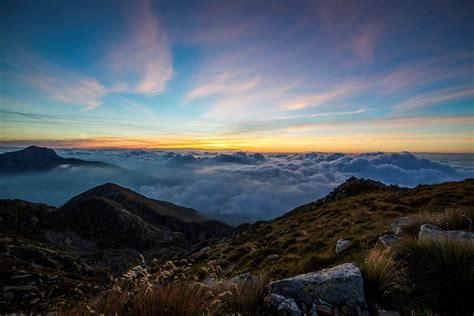

In [26]:
img, image_file = image_bing_search(search_term, idx=0)

print(image_file)
viewimage(filename=image_file, width=512)

In [27]:
prompt = get_caption(image_file)
prompt

'a mountain with clouds above it, landscape, cloud, outdoor, nature, sunrise, sky, mountain range, wilderness, ridge, fell, highland, massif, hill, summit, tundra, grass, sunset, mountain'

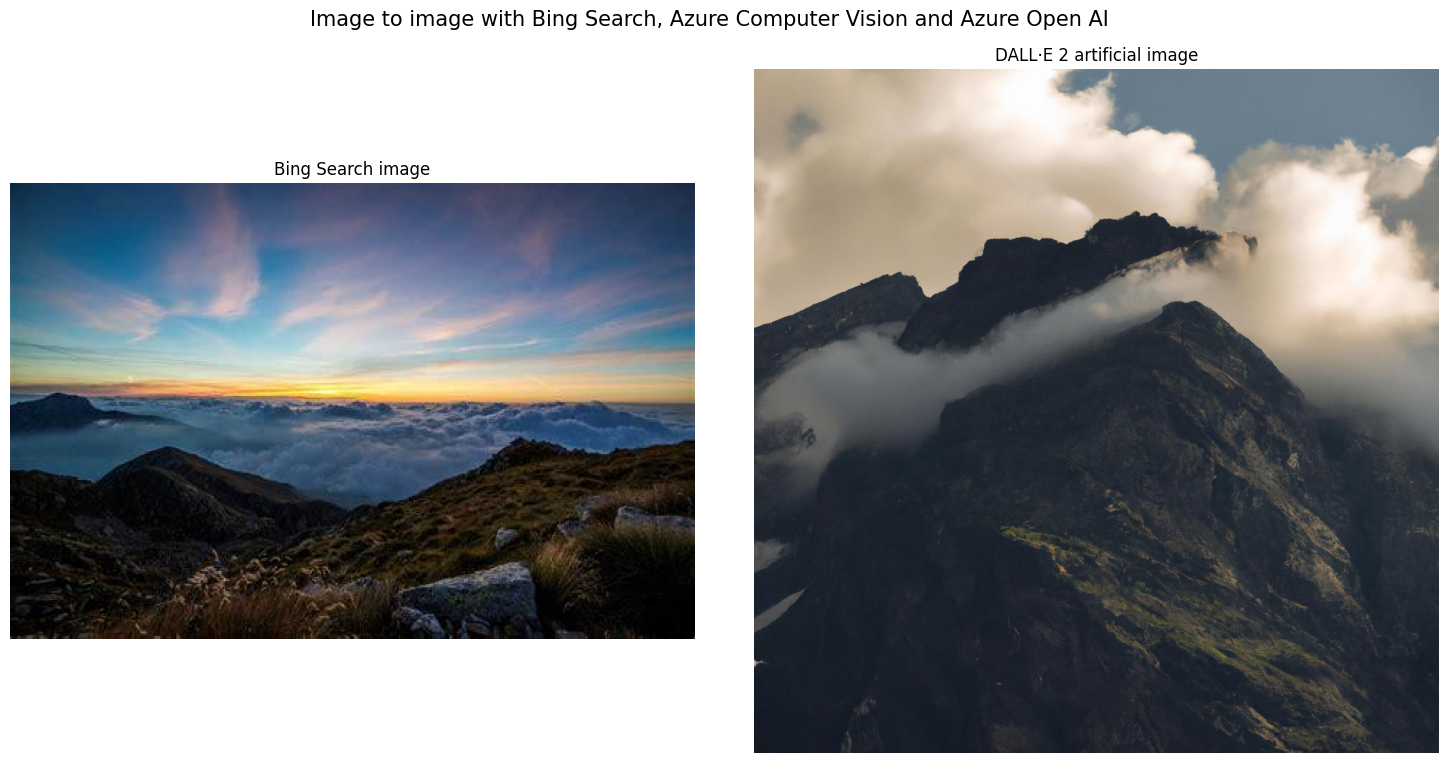

In [28]:
artificial_img, artificial_image = dalle2(prompt)

display_images(image_file, artificial_image)

### Test 6

In [29]:
search_term = "a close up of purple orchids"

bing_images/a close up of purple orchids.jpg


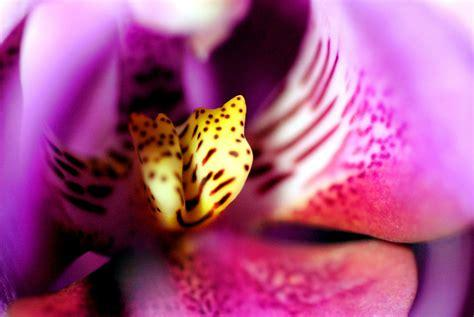

In [30]:
img, image_file = image_bing_search(search_term, idx=0)

print(image_file)
viewimage(filename=image_file, width=512)

In [31]:
prompt = get_caption(image_file)
prompt

'close-up of a purple flower, plant, flower, orchid, petal, purple, yellow'

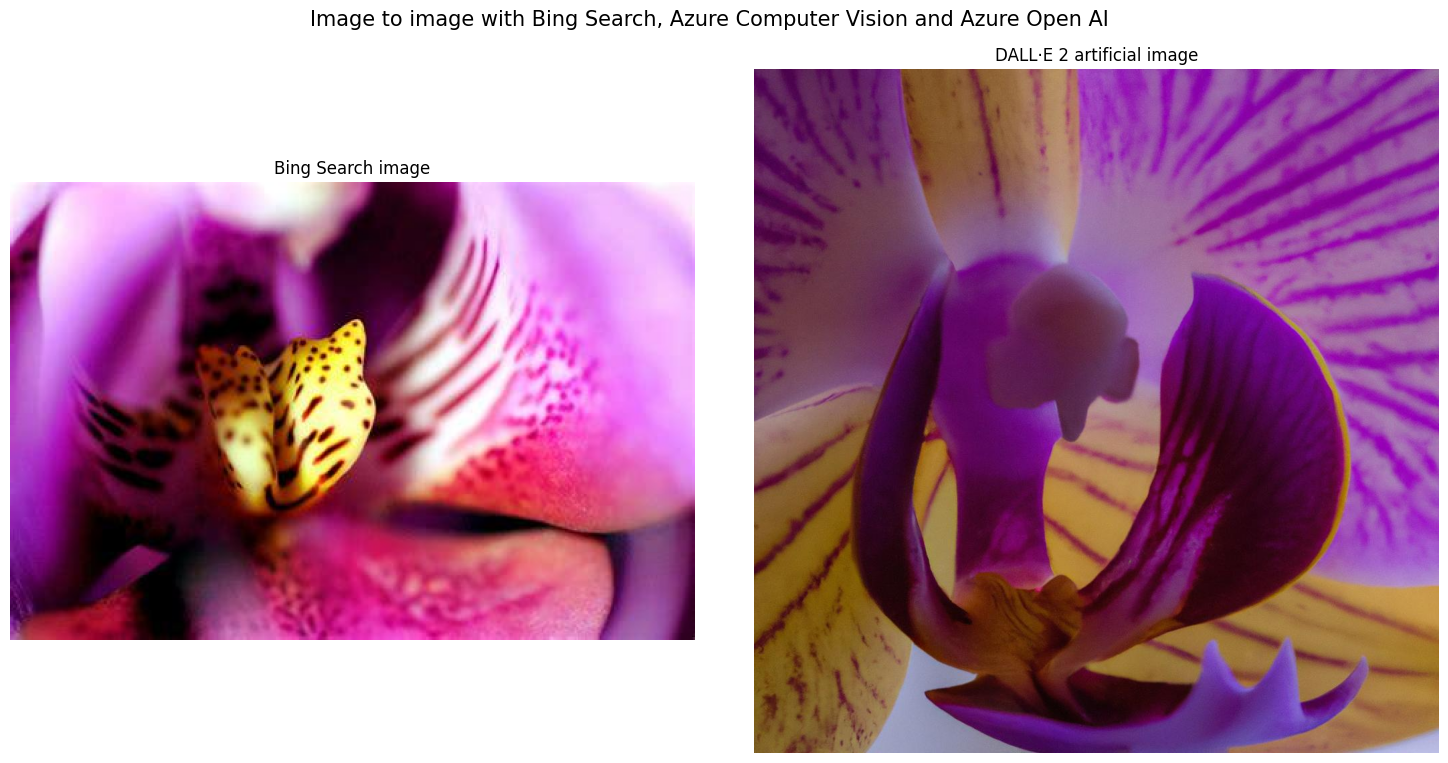

In [32]:
artificial_img, artificial_image = dalle2(prompt)

display_images(image_file, artificial_image)